In [9]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from os.path import exists
try:
    import csiborgtools
except ModuleNotFoundError:
    print("not found")
    import sys
    sys.path.append("../")
    import csiborgtools
import utils
import joblib
%load_ext autoreload
%autoreload 2

import cosmology_library as CL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
paths = csiborgtools.read.Paths()
hw = 0.05
darkskyps = np.genfromtxt("../plots/darksky.csv", delimiter=", ")

m = np.argsort(darkskyps[:, 0])
darkskyps[...] = darkskyps[m, ...]
darkskyps = 10**darkskyps

borg = np.genfromtxt("../plots/BORG_PS_Fig8.csv", delimiter=", ")
m = np.argsort(borg[:, 0])
borg[...] = borg[m, ...]
borg = 10**borg

In [48]:
pkreader = csiborgtools.read.PKReader(paths.get_ics, hw)

autoks, pks = pkreader.read_autos()

# crossks, xpks = pkreader.read_cross()

In [25]:
np.save("../plots/ks_{}.npy".format(hw), autoks)
np.save("../plots/pks_{}.npy".format(hw), pks)

In [51]:
import camb
from camb import model, initialpower

#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
h = 0.705
pars.set_cosmology(H0=h*100, ombh2=0.0486 * h**2, omch2=(0.307 - 0.04825) * h**2)
pars.InitPower.set_params(ns=0.9611)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=40)

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results = camb.get_results(pars)
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=autoks.min(), maxkh=autoks.max(), npoints = 200)

<IPython.core.display.Javascript object>


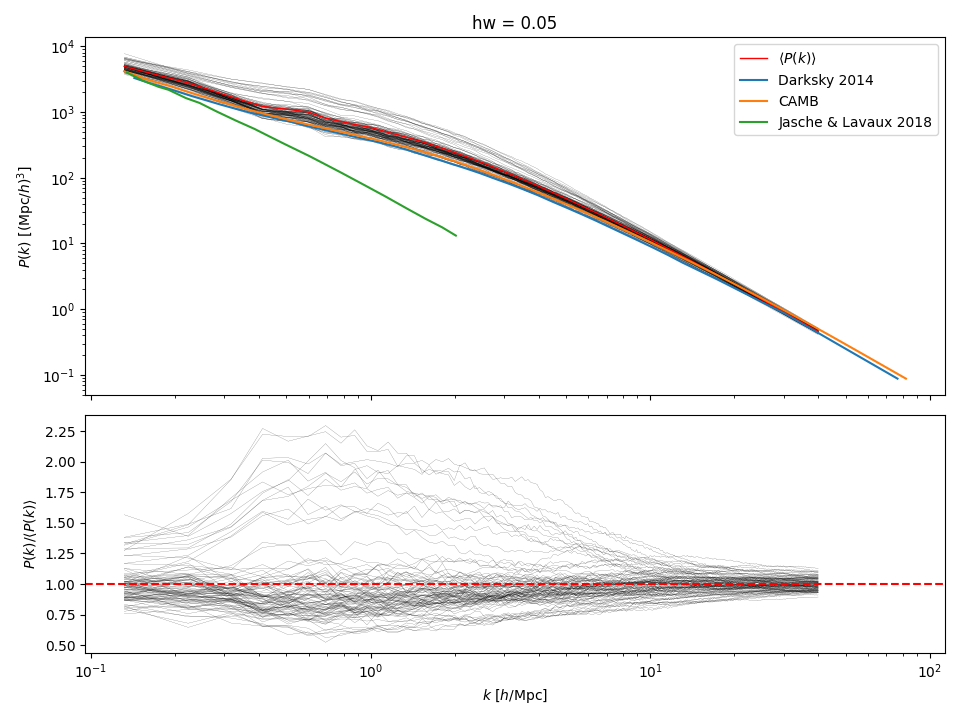

In [52]:
fig, axs = plt.subplots(nrows=2, figsize=[6.4*1.5, 4.8*1.5], sharex=True, height_ratios=[1.5, 1])
fig.subplots_adjust(hspace=0)
axs[0].set_title("hw = {}".format(hw))
m = autoks < 40
mu = np.mean(pks, axis=0)
for i in range(len(paths.get_ics)):
    axs[0].plot(autoks[m], pks[i, m], c="k", lw=0.1)
    axs[1].plot(autoks[m], pks[i, m] / mu[m], c="k", lw=0.1)
axs[0].plot(autoks[m], mu[m], c="red", lw=1, label=r"$\langle P(k) \rangle$")

m = (darkskyps[:, 0] > autoks.min()) & (darkskyps[:, 0] < autoks.max()) 
axs[0].plot(darkskyps[m, 0], darkskyps[m, 1], label=r"Darksky 2014")

axs[0].plot(kh_nonlin, pk_nonlin[0, :], label="CAMB")

m = (borg[:, 0] > autoks.min()) & (borg[:, 0] < autoks.max()) 
axs[0].plot(borg[m, 0], borg[m, 1], label="Jasche & Lavaux 2018")
axs[1].axhline(1, c="red", ls="--")

axs[1].set_xlabel(r"$k~\left[h / \mathrm{Mpc}\right]$")
axs[0].set_ylabel(r"$P(k)~\left[(\mathrm{Mpc} / h)^3 \right]$")
axs[1].set_ylabel(r"$P(k) / \langle P(k) \rangle $")
for i in range(2):
    axs[i].set_xscale("log")
#     axs[i].axvline(1 / 2.65, c="green", ls="--", label=r"$1 / 2.65~\left[h / \mathrm{Mpc}\right]$")
axs[0].set_yscale("log")
axs[0].legend()
plt.tight_layout()
fig.savefig("../plots/autopk_{}.png".format(hw), dpi=450)
plt.show()

<IPython.core.display.Javascript object>


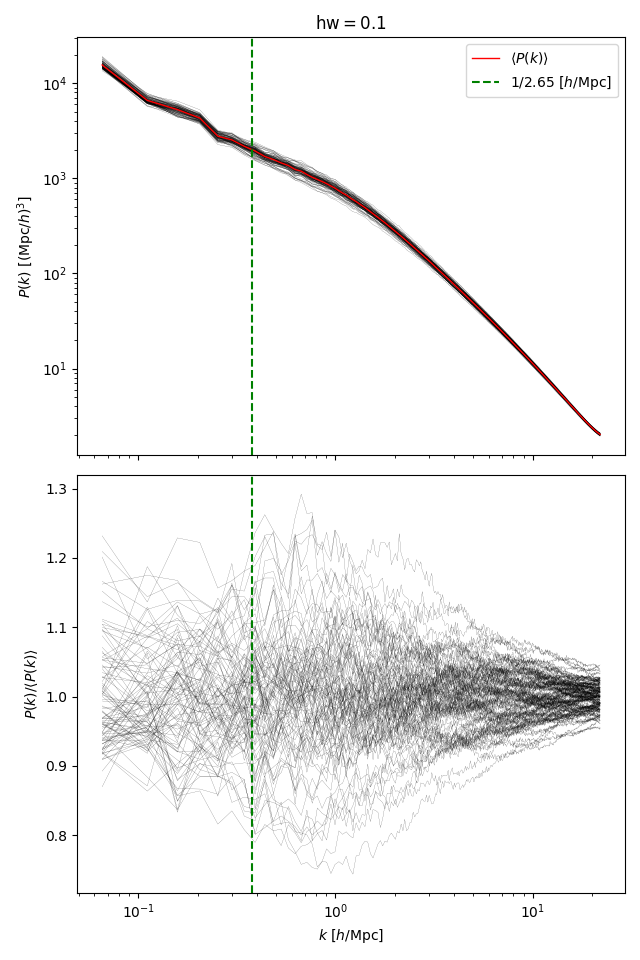

In [16]:
fig, axs = plt.subplots(nrows=2, figsize=[6.4, 4.8 * 2], sharex=True)
axs[0].set_title(r"$\mathrm{{hw}} = {}$".format(hw))
m = autoks < 22
mu = np.mean(pks, axis=0)
for i in range(len(paths.get_ics)):
    axs[0].plot(autoks[m], pks[i, m], c="k", lw=0.1)
    axs[1].plot(autoks[m], pks[i, m] / mu[m], c="k", lw=0.1)
axs[0].plot(autoks[m], mu[m], c="red", lw=1, label=r"$\langle P(k) \rangle$")
    


axs[1].set_xlabel(r"$k~\left[h / \mathrm{Mpc}\right]$")
axs[0].set_ylabel(r"$P(k)~\left[(\mathrm{Mpc} / h)^3 \right]$")
axs[1].set_ylabel(r"$P(k) / \langle P(k) \rangle $")
for i in range(2):
    axs[i].set_xscale("log")
    axs[i].axvline(1 / 2.65, c="green", ls="--", label=r"$1 / 2.65~\left[h / \mathrm{Mpc}\right]$")
axs[0].set_yscale("log")
axs[0].legend()
plt.tight_layout()
fig.savefig("../plots/auto_{}.png".format(hw))
plt.show()

<IPython.core.display.Javascript object>


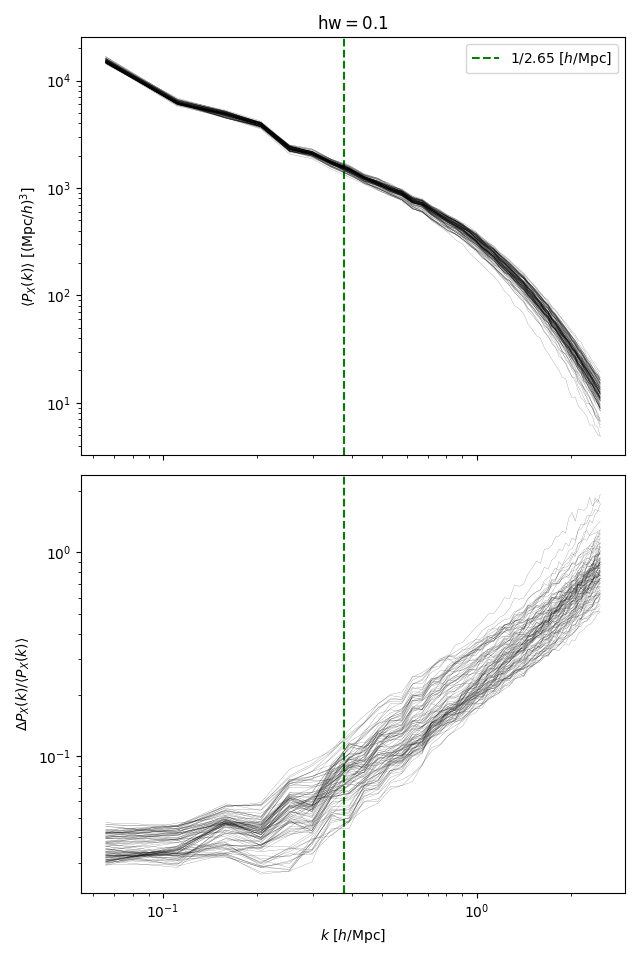

In [20]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

m = crossks < 2.5
fig, axs = plt.subplots(nrows=2, figsize=[6.4, 4.8 * 2], sharex=True)
axs[0].set_title(r"$\mathrm{{hw}} = {}$".format(hw))
for i in range(101):
    mu = np.mean(xpks[i, :, m], axis=1)
    std = np.std(xpks[i, :, m], axis=1)
    axs[0].plot(crossks[m], mu, c="k", lw=0.1)    
    axs[1].plot(crossks[m], std / mu, c="k", lw=0.1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].axvline(1 / 2.65, c="green", ls="--", label=r"$1 / 2.65~\left[h / \mathrm{Mpc}\right]$",
                   zorder=0)
axs[0].set_yscale("log")
axs[1].set_yscale("log")

axs[1].set_xlabel(r"$k~\left[h / \mathrm{Mpc}\right]$")
axs[0].set_ylabel(r"$\langle P_X(k) \rangle ~\left[(\mathrm{Mpc} / h)^3 \right]$")
axs[1].set_ylabel(r"$\Delta P_X(k) / \langle P_X(k) \rangle$")

axs[0].legend()
plt.tight_layout()
fig.savefig("../plots/cross_{}.png".format(hw))
fig.show()

# Auto-correlation

In [ ]:
fskel = "/mnt/extraspace/rstiskalek/csiborg/crosspk/out_{}_{}_{}.p"

autoks, autopks = None, None
for i, nsim in enumerate(paths.get_ics):
    pk = joblib.load(fskel.format(nsim, nsim, hw))
    x = pk.k3D
    y = pk.Pk[:, 0, 0]
    sel = x < 20
    if i == 0:
        autoks = np.full((len(paths.get_ics), np.sum(sel)), np.nan)
        autopks = np.full_like(autoks, np.nan)
    
    autoks[i, :] = x[sel]
    autopks[i, :] = y[sel]        

In [ ]:
plt.figure()
for i in range(len(paths.get_ics)):
    plt.plot(autoks[i, :], autopks[i, :], c="k", lw=0.1)
plt.plot(np.mean(autoks, axis=0), np.mean(autopks, axis=0), label="CSiBORG", c="k", lw=1)
    
m = (darkskyps[:, 0] > 0.01) & (darkskyps[:, 0] < 20) 
plt.plot(darkskyps[m, 0], darkskyps[m, 1], label=r"Darksky 2014")

plt.axvline(1 / 4, c="red", ls="--", label=r"$1/4~ h / \mathrm{Mpc}$")

plt.legend()
plt.xlabel(r"$k~\left[h / \mathrm{Mpc}\right]$")
plt.ylabel(r"$P(k) ~ \left[(\mathrm{Mpc} / h)^3 \right]$")
plt.yscale("log")
plt.xscale("log")
plt.savefig("../plots/autocorr.png", dpi=450)
plt.show()

# Cross-correlation

In [ ]:
fskel = "/mnt/extraspace/rstiskalek/csiborg/crosspk/out_{}_{}_{}.p"

ic0 = paths.get_ics[25]
crossks, crosspks = None, None
i = 0
for ic in paths.get_ics:
    if ic == ic0:
        continue
    ics = (ic0, ic)
    if ic0 > ic:
        ics = ics[::-1]
        
    pk = joblib.load(fskel.format(*ics, hw))
    x = pk.k3D
    y = pk.XPk[:, 0, 0]
    sel = x < 2
    if i == 0:
        crossks = np.full((100, np.sum(sel)), np.nan)
        crosspks = np.full_like(crossks, np.nan)
    
    crossks[i, :] = x[sel]
    crosspks[i, :] = y[sel]
    
    i += 1


In [ ]:
plt.figure()
for i in range(100):
    plt.plot(crossks[i, :], crosspks[i, :], c="k", lw=0.1)
plt.axvline(1 / 2.65, c="red", ls="--")
# plt.plot(autoks[25, :], autopks[25, :], c="red", label="Autocorrelation")
plt.xlabel(r"$k~\left[h / \mathrm{Mpc}\right]$")
plt.ylabel(r"$P(k) ~ \left[(\mathrm{Mpc} / h)^3 \right]$")
plt.yscale("log")
plt.xscale("log")
plt.savefig("../plots/crosscorr.png", dpi=450)
plt.show()

In [ ]:
ic1 = 7444
ic2 = 7516

fpath = "/mnt/extraspace/rstiskalek/csiborg/crosspk/out_{}_{}_{}.p"
darkskyps = np.genfromtxt("../plots/darksky.csv", delimiter=", ")

In [ ]:
pk = joblib.load(fpath.format(ic1, ic2, 0.2))

In [ ]:
plt.figure()

plt.plot(pk.k3D, pk.Pk[:, 0, 0], label="CSiBORG")
plt.plot(pk.k3D, pk.XPk[:, 0, 0], label="CSiBORG cross")
# plt.plot(pk2.k3D / L, pk2.Pk[:, 0, 0] * L**3, label="CSiBORG1024")


# m = np.argsort(darkskyps[:, 0])
# plt.plot(10**darkskyps[:, 0][m], 10**darkskyps[:, 1][m], label=r"Darksky 2014")


plt.yscale("log")
plt.xscale("log")

plt.axvline(1 / 4, c="red", ls="--", label=r"$1/4~ h / \mathrm{Mpc}$")

plt.xlabel(r"$k~\left[h / \mathrm{Mpc}\right]$")
plt.ylabel(r"$P(k) ~ \left[(\mathrm{Mpc} / h)^3 \right]$")

plt.legend()
plt.tight_layout()
# plt.savefig("../plots/pk.png", dpi=300)

plt.show()

In [ ]:
# dx = box.kpc2box(300e3) / 2
dx = 0.5

In [ ]:
m = ((0.5 - dx < particles['x']) & (particles['x'] < 0.5 + dx)
     & (0.5 - dx < particles['y']) & (particles['y'] < 0.5 + dx)
     & (0.5 - dx < particles['z']) & (particles['z'] < 0.5 + dx))

particles = particles[m]

particles['x'] = (particles['x'] - 0.5 + dx) / (2*dx)
particles['y'] = (particles['y'] - 0.5 + dx) / (2*dx)
particles['z'] = (particles['z'] - 0.5 + dx) / (2*dx)

In [ ]:
plt.figure()
plt.hist(particles['y'], bins=20)

plt.show()

In [ ]:
particles['x'] = (particles['x'] - 0.5 + dx) / (2*dx)
particles['y'] = (particles['y'] - 0.5 + dx) / (2*dx)
particles['z'] = (particles['z'] - 0.5 + dx) / (2*dx)

In [ ]:
# pk2 = joblib.load("/mnt/extraspace/rstiskalek/csiborg/crosspk/out_{}_{}.p".format(ic, ic))

In [ ]:
# L = box.box2mpc(1)
# particles["x"] *= L
# particles["y"] *= L
# particles["z"] *= L

In [ ]:
field = csiborgtools.field.DensityField(particles, box.box2mpc(2*dx) * box.h, box)

# field._boxsize = 1. # box.box2mpc(0.2) * box.h

In [ ]:
PK = field.auto_powerspectrum(1024)
# PK = pk

In [ ]:
borg_ps = np.genfromtxt("../plots/BORG_PS_Fig8.csv", delimiter=", ")
darkskyps = np.genfromtxt("../plots/darksky.csv", delimiter=", ")

In [ ]:
plt.figure()

plt.plot(PK.k3D, PK.Pk[:, 0], label="CSiBORG")
# plt.plot(pk2.k3D / L, pk2.Pk[:, 0, 0] * L**3, label="CSiBORG1024")


# plt.plot(10**borg_ps[:, 0], 10**borg_ps[:, 1], label=r"Jasche & Lavaux 2018 Fig. 8")
m = np.argsort(darkskyps[:, 0])
plt.plot(10**darkskyps[:, 0][m], 10**darkskyps[:, 1][m], label=r"Darksky 2014")


plt.yscale("log")
plt.xscale("log")

plt.axvline(1 / 4, c="red", ls="--", label=r"$1/4~ h / \mathrm{Mpc}$")

plt.xlabel(r"$k~\left[h / \mathrm{Mpc}\right]$")
plt.ylabel(r"$P(k) ~ \left[(\mathrm{Mpc} / h)^3 \right]$")

plt.legend()
plt.tight_layout()
# plt.savefig("../plots/pk.png", dpi=300)

plt.show()

In [ ]:
paths = csiborgtools.read.Paths()
cat = csiborgtools.read.CombinedCatalogue(paths, min_m500=1e13, max_dist=210)

In [ ]:
matcher = csiborgtools.match.RealisationsMatcher(cat)

In [ ]:
n = 0
match = matcher.cross_knn_position_single(n, 10)

In [ ]:
ids = np.where(cat[n]["m200"] > 10**15.25)[0]
print(ids.size)
k = np.random.choice(ids)

In [ ]:
col = plt.rcParams['axes.prop_cycle'].by_key()['color']


plt.figure()

r200 = cat[n]["r200"][k]
m200 = cat[n]["m200"][k]
vel = cat[n].angmomentum[k]
    
plt.title(r"$\log M_{{200c}} / M_\odot = {:.3f}$".format(np.log10(m200)))
for i, j in enumerate(matcher.search_sim_indices(n)):
    indxs, dist = match[i]
    indxs = indxs[k]
    dist = dist[k]
    
    sim = matcher.cosine_similarity(vel, cat[j].angmomentum[indxs])
    sim = (sim + 1) / 2
    
    dlogmass = np.abs(np.log10(cat[j]["m200"][indxs] / m200))
    
    plt.scatter(dist / r200, dlogmass, s=50 * sim)
    
    
plt.xlabel(r"$\Delta r_i / R_{200c}$")
plt.ylabel(r"$|\log \dfrac{M_i}{M_{200c}}|$")
plt.tight_layout()
plt.savefig("../plots/aligned.png", dpi=450)
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(9, 3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0)
for m, k in enumerate(ids):
    r200 = cat[n]["r200"][k]
    m200 = cat[n]["m200"][k]
    
    axs[m].set_title(r"$\log M_{{200c}} / M_\odot = {:.3f}$".format(np.log10(m200)))
    for i, j in enumerate(matcher.search_sim_indices(n)):
        indxs, dist = match[i]
        indxs = indxs[k]
        dist = dist[k]

        dlogmass = np.abs(np.log10(cat[j]["m200"][indxs] / m200))
        axs[m].scatter(dist / r200, dlogmass)
    
    
for i in range(3):
    axs[i].set_xlabel(r"$\Delta r_i / R_{200c}$")
axs[0].set_ylabel(r"$|\log \dfrac{M_i}{M_{200c}}|$")
plt.tight_layout(w_pad=0)
# plt.savefig("../plots/lowest_massive.png", dpi=450)
fig.show()

In [ ]:
plt.figure()
for k in range(cat.N-1):
    plt.scatter(x[k, :, 1], x[k, :, 2])

    
plt.xlabel(r"$\Delta r_i / R_{200c}$")
plt.ylabel(r"$|\log \dfrac{M_i}{M_{200c}}|$")
plt.savefig("../plots/example.png", dpi=450)
plt.show()

In [ ]:
x[:, 0, 2]

In [ ]:
cat.cross_knn_position(0, 0)

In [ ]:
x = cat.positions[6, :].reshape(-1, 3)


# x = np.asarray([0., 0., 0.]).reshape(-1, 3)

In [ ]:
cat.knn_position(x, 5)

In [ ]:
dist, knns = cat.knn_position([5, 9], 5)

In [ ]:
dist

In [ ]:
knns

In [ ]:
model = NearestNeighbors()

In [ ]:
model.fit(cat[0].positions)

In [ ]:
p = cat[0].positions[:2, :].reshape(-1, 3)

In [ ]:
p

In [ ]:
model.kneighbors(p, n_neighbors=2)

In [ ]:
cat = csiborgtools.io.Catalogue(9844, 1016, minimum_m500=0)

In [ ]:
cat["dec"].size

In [ ]:
planck = csiborgtools.io.PlanckClusters("../data/HFI_PCCS_SZ-union_R2.08.fits")

In [ ]:
mcxc = csiborgtools.io.MCXCClusters("../data/mcxc.fits")

In [ ]:
planck.match_to_mcxc(mcxc)

In [ ]:
planck["MSZ"]

In [ ]:
planck.data.dtype.names

In [ ]:
csiborgtools.io.get_csiborg_ids("/mnt/extraspace/hdesmond")

In [ ]:
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units

In [ ]:
Nsim = 9844
Nsnap = 1016
# data, box = utils.load_processed(Nsim, Nsnap)
data, box = utils.load_processed(Nsim, Nsnap)

In [ ]:
X = np.vstack([data["peak_{}".format(p)] for p in ("x", "y", "z")]).T

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neighbors = NearestNeighbors()

In [ ]:
neighbors.fit(X)

In [ ]:
p = X[0, :]

neighbors.kneighbors(p.reshape(-1,3))

In [ ]:
data["peak_y"]

In [ ]:
zcosmo = box.box2cosmoredshift(data["dist"])
z

In [ ]:
plt.figure()

m = data["m500"] > 1e13
plt.scatter(data["ra"][m], data["dec"][m], label="CSiBORG", s=3)
plt.scatter(groups["RA"], groups["DEC"], label="2M++ galaxy groups", s=3, marker="x")



plt.show()

In [ ]:
RAcoma = (12 +  59/60 + 48.7 / 60**2) * 15
DECcoma = 27 + 58 / 60 + 50 / 60**2


RAvirgo = (12 + 27 / 60) * 15
DECvirgo = 12 + 43/60



plt.figure()


plt.scatter(mcxc["RAdeg"], mcxc["DEdeg"], label="MCXC")
plt.scatter(planck["RA"], planck["DEC"], label="Plank",s=8, c="red")

plt.scatter(RAcoma, DECcoma, label="Coma", s=30, marker="x")
plt.scatter(RAvirgo, DECvirgo, label="Virgo", s=30, marker="x")

plt.legend(framealpha=0.5)
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("Clusters below 200 Mpc")
plt.savefig("../plots/clusters_radec.png", dpi=450)

plt.show()

In [ ]:
plt.figure()

plt.scatter(mcxc["COMDIST"], mcxc["M500"], label="MCXC")
# yerr = np.vstack([planck["MSZ"] - planck["MSZ_ERR_LOW"],
#                   planck["MSZ_ERR_UP"] - planck["MSZ"]])
yerr = np.vstack([planck["MSZ_ERR_LOW"], planck["MSZ_ERR_UP"]])
plt.errorbar(planck["COMDIST"], planck["MSZ"], yerr, label="Plank", fmt=" ", capsize=3, color="red")

plt.yscale("log")
plt.legend()
plt.title("Clusters below 200 Mpc")
plt.xlabel(r"$D_{\rm c} / \mathrm{Mpc}$")
plt.ylabel(r"$M_{\rm 500c} / M_\odot$")
# plt.savefig("../plots/clusters_mass_dist.png", dpi=450)

plt.show()

In [ ]:
d["MCXC"]

In [ ]:
plt.figure()
# plt.scatter(d["RAdeg"], d["DEdeg"], s=1)
plt.scatter(d["z"], d["M500"], s=1)

plt.yscale("log")
plt.show()

In [ ]:
Nsim = 9844
Nsnap = 1016

data = utils.load_processed(Nsim, Nsnap)

In [ ]:
bins = np.arange(11.8, 15.4, 0.2)


plt.figure()
x, mu, std = csiborgtools.match.number_density(data, "m200", bins, 200, True)
plt.errorbar(x, mu, std, capsize=4, label=r"$M_{200c}$")

x, mu, std = csiborgtools.match.number_density(data, "m500", bins, 200, True)
plt.errorbar(x, mu, std, capsize=4, label=r"$M_{500c}$")

x, mu, std = csiborgtools.match.number_density(data, "totpartmass", bins, 200, True)
plt.errorbar(x, mu, std, capsize=4, label=r"$M_{\rm tot}$")

x, mu, std = csiborgtools.match.number_density(data, "mass_mmain", bins, 200, True)
plt.errorbar(x, mu, std, capsize=4, label=r"$M_{\rm mmain}$")

plt.legend()

plt.yscale("log")
plt.xscale("log")

plt.ylabel(r"$\phi / (\mathrm{Mpc}^{-3})~\mathrm{dex}$")
plt.xlabel(r"$M_{\rm x}$")
plt.tight_layout()
plt.savefig("../plots/HMF.png", dpi=450)
plt.show()

In [ ]:
nfw = csiborgtools.fits.NFWProfile()
m200_nfw = nfw.enclosed_mass(data["r200"], data["Rs"], data["rho0"])



plt.figure()

plt.scatter(data["m200"], m200_nfw, s=1)
t = np.linspace(1e11, 1e15)
plt.plot(t, t, c="red", ls="--", lw=1.5)
plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$M_{200c}$")
plt.ylabel(r"$M_{\mathrm{NFW}, 200c}$")
plt.tight_layout()
plt.savefig("../plots/enclosed_vs_nfw.png", dpi=450)
plt.show()

In [ ]:
logm200 = np.log10(data["m200"])
conc = data["conc"]

N = 10
bins = np.linspace(logm200.min(), logm200.max(), N)
x = [0.5*(bins[i] + bins[i + 1]) for i in range(N-1)]
y = np.full((N - 1, 3), np.nan)
for i in range(N - 1):
    mask = (logm200 >= bins[i]) & (logm200 < bins[i + 1]) & np.isfinite(conc)
    y[i, :] = np.percentile(conc[mask], [14, 50, 84])


    
    
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.4, 6.4 * 1))
fig.subplots_adjust(hspace=0)
axs[0].plot(x, y[:, 1], c="red", marker="o")
axs[0].fill_between(x, y[:, 0], y[:, 2], color="red", alpha=0.25)
axs[1].hist(logm200, bins="auto", log=True)

for b in bins:
    for i in range(2):
        axs[i].axvline(b, c="orange", lw=0.5)

axs[0].set_ylim(2, 10)
axs[1].set_xlabel(r"$M_{200c}$")
axs[0].set_ylabel(r"$c_{200c}$")
axs[1].set_ylabel(r"Counts")

plt.tight_layout(h_pad=0)
plt.savefig("../plots/mass_concentration.png", dpi=450)
plt.show()